<a href="https://colab.research.google.com/gist/Yong-Zhuang/f4e32f796aef441de9b7d153e4c4d52a/discrete-data-normality-test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Normality and Equal-Variance Tests on Discrete Data with Added Noise
### Objective
To make a dataset with discrete values continuous, we can add some noise by using a random function to generate small deviations from the original values. After adding noise, we should check the normality of the data using appropriate statistical tests. If the data with noise passes the normality test, we can consider using it for two-way ANOVA analysis.

### Noise
- Generated from a normal distribution
- Mean: 0
- Std: 0.07

### Normality Test
Every data will take the following normality tests:
- Shapiro Wilk
- Anderson Darling
- Lilliefors

### Equal-variance Test
- Levene's test

In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import shapiro, kstest, norm, anderson, chisquare, levene
from statsmodels.stats.diagnostic import lilliefors
from google.colab import drive

drive.mount('/content/drive')
directory_path = "./drive/MyDrive/Data/dataset_normality/"
significance_level = 0.05


Mounted at /content/drive


In [ ]:
!pip install statsmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
def shapiro_wilk_test(series):
  statistic, p_value = shapiro(series)
  # If the p-value is less than the significance level (e.g., 0.05), we reject the null hypothesis and conclude that the data is not normally distributed.
  #title = f"Is normal distribution? {shapiro_test[1]>=significance_level} -- Statistic: {shapiro_test[0]}; P-value: {shapiro_test[1]}; "
  return p_value>=significance_level, statistic, p_value

def anderson_darling_test(series):
  anderson_result = anderson(series, 'norm')
  # If the Anderson-Darling statistic is greater than the critical value at the chosen significance level, you can reject the null hypothesis and conclude that the sample data is not normally distributed
  critical_value = anderson_result.critical_values[np.where(anderson_result.significance_level == significance_level*100)[0]]
  # print(anderson_result.significance_level)
  #title = f"Is normal distribution? {anderson_result.statistic<=critical_value[0]} -- Statistic: {anderson_result.statistic}; critical_values: {critical_value[0]}; "
  return anderson_result.statistic<=critical_value[0], anderson_result.statistic, critical_value[0]

def kolmogorov_smirnov_test(series):
  statistic, p_value  = kstest(series, 'norm')
  #If the p-value is less than the significance level (e.g., 0.05), we reject the null hypothesis and conclude that the data is not normally distributed. 
  #title = f"Is normal distribution? {p_value>=significance_level} -- Statistic: {ks_statistic}; P-value: {p_value}; "
  return p_value>=significance_level, statistic, p_value

def lilliefors_test(series):
  lilliefors_statistic, p_value = lilliefors(series, dist='norm')
  #If the p-value is less than the significance level (e.g., 0.05), we reject the null hypothesis and conclude that the data is not normally distributed. 
  #title = f"Is normal distribution? {p_value>=significance_level} -- Statistic: {lilliefors_statistic}; P-value: {p_value}; "
  return p_value>=significance_level, lilliefors_statistic, p_value

def levene_test(series_list):
  statistic, p_value = levene(*series_list)
  # If the p-value is less than the chosen significance level (e.g., 0.05), we can reject the null hypothesis of equal variances among the groups.. 
  title = f"Equal variances among the groups? {p_value>=significance_level} -- Statistic: {statistic}; P-value: {p_value}; "
  return p_value>=significance_level, statistic, p_value

test_functions = {"Shapiro Wilk":shapiro_wilk_test, "Anderson Darling": anderson_darling_test, "Lilliefors": lilliefors_test}#, "chi_squared": chi_squared_goodness_of_fit_test, "Kolmogorov Smirnov": kolmogorov_smirnov_test,

def dataset_normality_analysis():
  # get list of file names in directory
  file_names = os.listdir(directory_path)
  # filter file names to include only Excel files
  excel_file_names = [f for f in file_names if f.endswith('contra_VF.xlsx') or f.endswith('Ipsi_VF.xlsx')]

  # loop through Excel files and read them into Pandas DataFrames
  for file_name in excel_file_names:
      file_path = os.path.join(directory_path, file_name)
      # Load the Excel file into a pandas dataframe
      xlsx_file = pd.ExcelFile(file_path)
      # Iterate through each sheet in the Excel file
      ds = []
      results = {}
      fig, axs = plt.subplots(2, len(xlsx_file.sheet_names), figsize=(5*len(xlsx_file.sheet_names),7))
      for i, sheet_name in enumerate(xlsx_file.sheet_names):
          result = {
            "Test": [],
            "Normality": [],
            "Statistic": [],
            "P-value/critical": [],
            }
          # Load the sheet into a pandas dataframe
          df = pd.read_excel(xlsx_file, sheet_name=sheet_name, header=None)
          series = df.stack().reset_index(drop=True)
          noise = np.random.normal(0, 0.07, len(series))
          series = series+noise
          ds.append(series)
          # Apply normality test on the data in the dataframe
          title = f"File: {file_name}; Sheet name: {sheet_name}:\n"
          for name, fun in test_functions.items():
            # title += f"{name}: {fun(series)}\n"
            is_normal, stat, p_value = fun(series)
            result["Test"].append(name)
            result["Normality"].append(is_normal)
            result["Statistic"].append(f"{round(stat, 3)}")
            result["P-value/critical"].append(round(p_value, 3))

          # print(title)
          sns.histplot(series, ax=axs[1,i], kde=True, stat='density', color='steelblue')
          axs[1,i].set_xlabel('Data')
          axs[1][i].set_ylabel('Density')

          # Plot QQ plot in the second subplot
          res = norm.fit(series)
          sm.qqplot(series, line='s', ax=axs[0][i])
          axs[0][i].set_xlabel('Theoretical quantiles')
          axs[0][i].set_ylabel('Sample quantiles')
          axs[0][i].set_title(f'Data: {file_name} - {sheet_name}\n Normal distribution fit\n(mean={res[0]:.2f}, std={res[1]:.2f})')

          df = pd.DataFrame(result)
          # df.style.set_caption(f"{file_name} - {sheet_name}")
          # axs[2][i].table(cellText=df.values, colLabels=df.columns, loc='center')
          results[(file_name, sheet_name)]=df
          # Adjust spacing between subplots
          plt.subplots_adjust(wspace=0.3, hspace=0.3)

      # Show the plot
      is_equal_variance, stat, p_value = levene_test(ds)
      print('\033[1m' )
      print("**********************************************************************************************************")
      print(f"Dataset: {file_name};\n Do these groups have equal variances? {is_equal_variance} -- Statistic: {stat}; P-value: {p_value};")
      print("**********************************************************************************************************")
      df_results = pd.concat(results)
      #df_results = df_results.round(3)
      display(df_results)
      plt.show()
        


**********************************************************************************************************
Dataset: Cre_contra_VF.xlsx;
 Do these groups have equal variances? True -- Statistic: 0.47510129660625733; P-value: 0.6230476864950041;
**********************************************************************************************************


Test  Normality Statistic  \
Cre_contra_VF.xlsx NpHR-Pre  0      Shapiro Wilk      False     0.939   
                             1  Anderson Darling      False     0.758   
                             2        Lilliefors       True     0.131   
                   NpHR-Dur  0      Shapiro Wilk      False      0.89   
                             1  Anderson Darling      False     1.065   
                             2        Lilliefors      False     0.144   
                   NpHR-Post 0      Shapiro Wilk      False     0.925   
                             1  Anderson Darling      False     0.768   
                             2        Lilliefors       True     0.105   

                                P-value/critical  
Cre_contra_VF.xlsx NpHR-Pre  0             0.037  
                             1             0.725  
                             2             0.088  
                   NpHR-Dur  0             0.001  
                             1             0.725  
                             2             0.041  
                   NpHR-Post 0             0.013  
                             1             0.725  
                             2             0.351

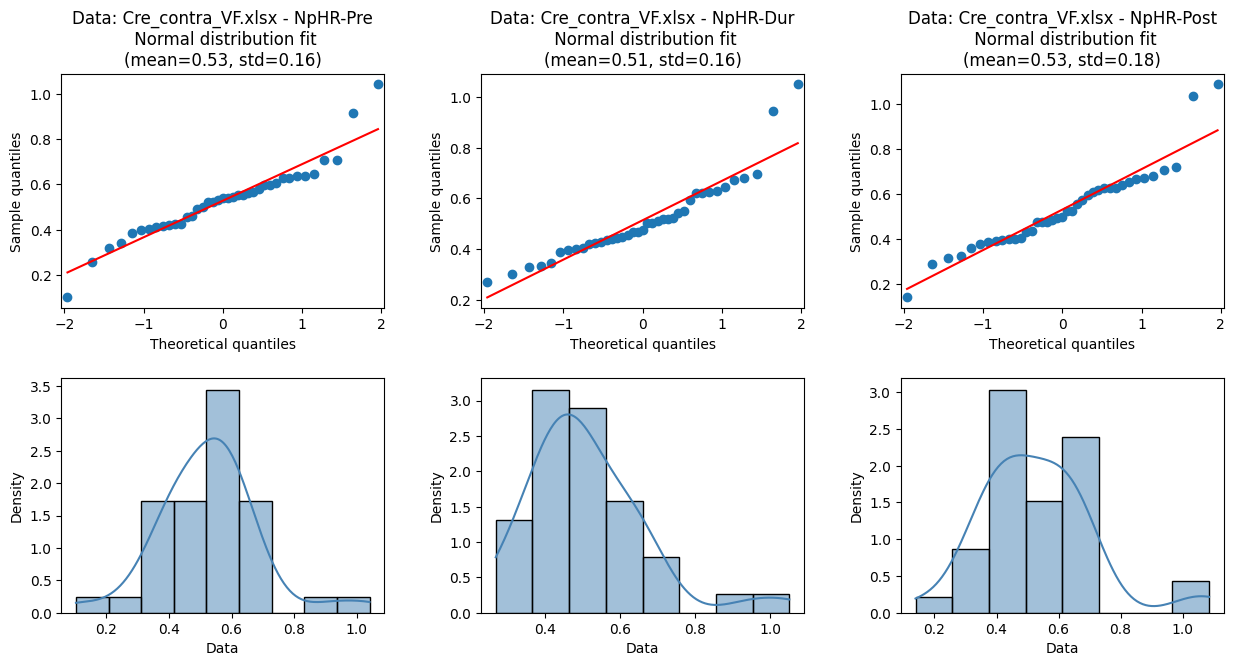


**********************************************************************************************************
Dataset: Cre_Ipsi_VF.xlsx;
 Do these groups have equal variances? True -- Statistic: 2.0239201518972347; P-value: 0.13685727944235096;
**********************************************************************************************************


Test  Normality Statistic  \
Cre_Ipsi_VF.xlsx NpHR-Pre  0      Shapiro Wilk       True      0.97   
                           1  Anderson Darling       True     0.309   
                           2        Lilliefors       True     0.082   
                 NpHR-Dur  0      Shapiro Wilk      False     0.915   
                           1  Anderson Darling      False     1.002   
                           2        Lilliefors      False     0.162   
                 NpHR-Post 0      Shapiro Wilk       True      0.95   
                           1  Anderson Darling       True     0.585   
                           2        Lilliefors       True     0.129   

                              P-value/critical  
Cre_Ipsi_VF.xlsx NpHR-Pre  0             0.386  
                           1             0.725  
                           2             0.725  
                 NpHR-Dur  0             0.006  
                           1             0.725  
                           2             0.012  
                 NpHR-Post 0             0.085  
                           1             0.725  
                           2             0.098

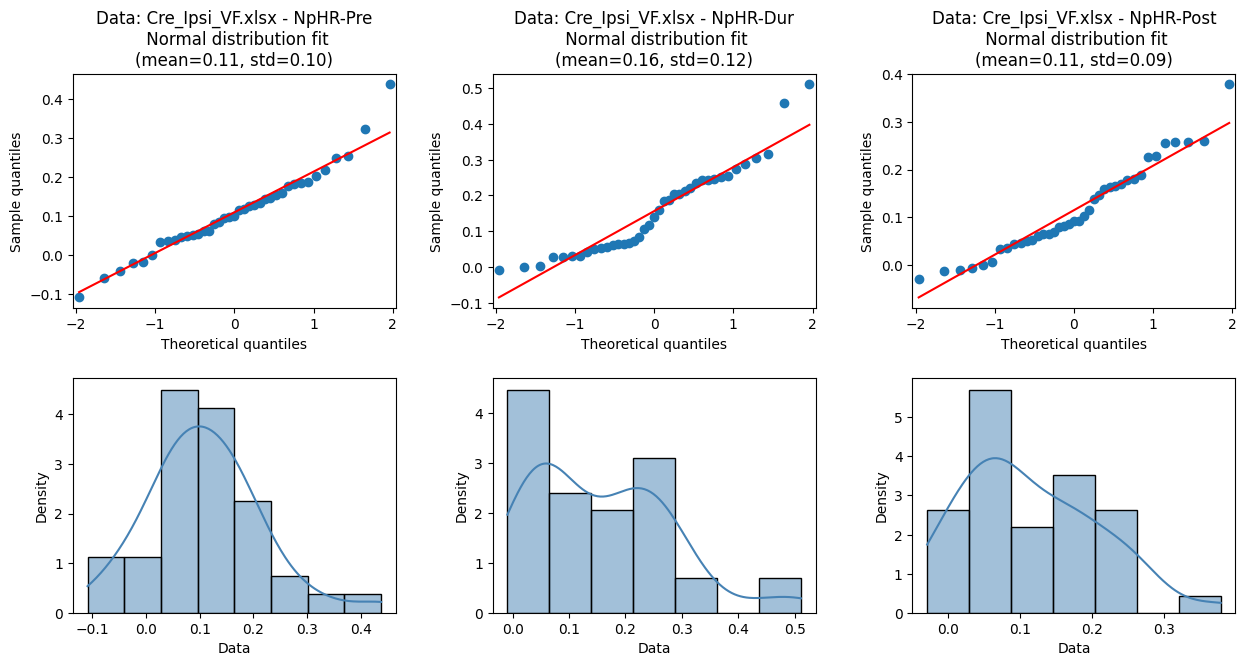


**********************************************************************************************************
Dataset: NpHR_contra_VF.xlsx;
 Do these groups have equal variances? True -- Statistic: 0.6251596251319107; P-value: 0.5362451125472245;
**********************************************************************************************************


Test  Normality Statistic  \
NpHR_contra_VF.xlsx NpHR-Pre  0      Shapiro Wilk      False     0.946   
                              1  Anderson Darling      False     0.827   
                              2        Lilliefors       True     0.087   
                    NpHR-Dur  0      Shapiro Wilk      False     0.955   
                              1  Anderson Darling       True     0.485   
                              2        Lilliefors       True     0.069   
                    NpHR-Post 0      Shapiro Wilk      False     0.959   
                              1  Anderson Darling       True      0.34   
                              2        Lilliefors       True      0.06   

                                 P-value/critical  
NpHR_contra_VF.xlsx NpHR-Pre  0             0.006  
                              1             0.746  
                              2             0.295  
                    NpHR-Dur  0             0.018  
                              1             0.746  
                              2             0.668  
                    NpHR-Post 0             0.029  
                              1             0.746  
                              2             0.838

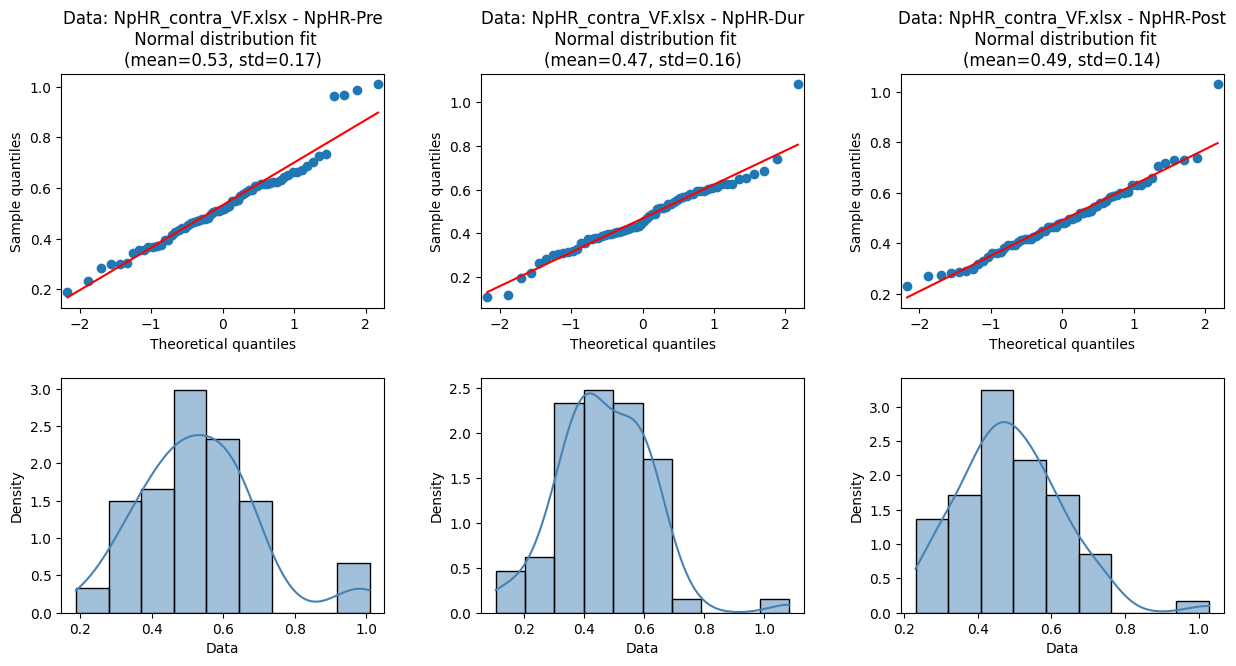


**********************************************************************************************************
Dataset: NpHR_Ipsi_VF.xlsx;
 Do these groups have equal variances? False -- Statistic: 25.555952259074726; P-value: 1.3897735508733595e-10;
**********************************************************************************************************


Test  Normality Statistic  \
NpHR_Ipsi_VF.xlsx NpHR-Pre  0      Shapiro Wilk       True     0.985   
                            1  Anderson Darling       True     0.415   
                            2        Lilliefors       True     0.083   
                  NpHR-Dur  0      Shapiro Wilk      False     0.921   
                            1  Anderson Darling      False     2.224   
                            2        Lilliefors      False     0.178   
                  NpHR-Post 0      Shapiro Wilk       True     0.983   
                            1  Anderson Darling       True     0.336   
                            2        Lilliefors       True     0.075   

                               P-value/critical  
NpHR_Ipsi_VF.xlsx NpHR-Pre  0             0.610  
                            1             0.746  
                            2             0.384  
                  NpHR-Dur  0             0.000  
                            1             0.746  
                            2             0.001  
                  NpHR-Post 0             0.521  
                            1             0.746  
                            2             0.522

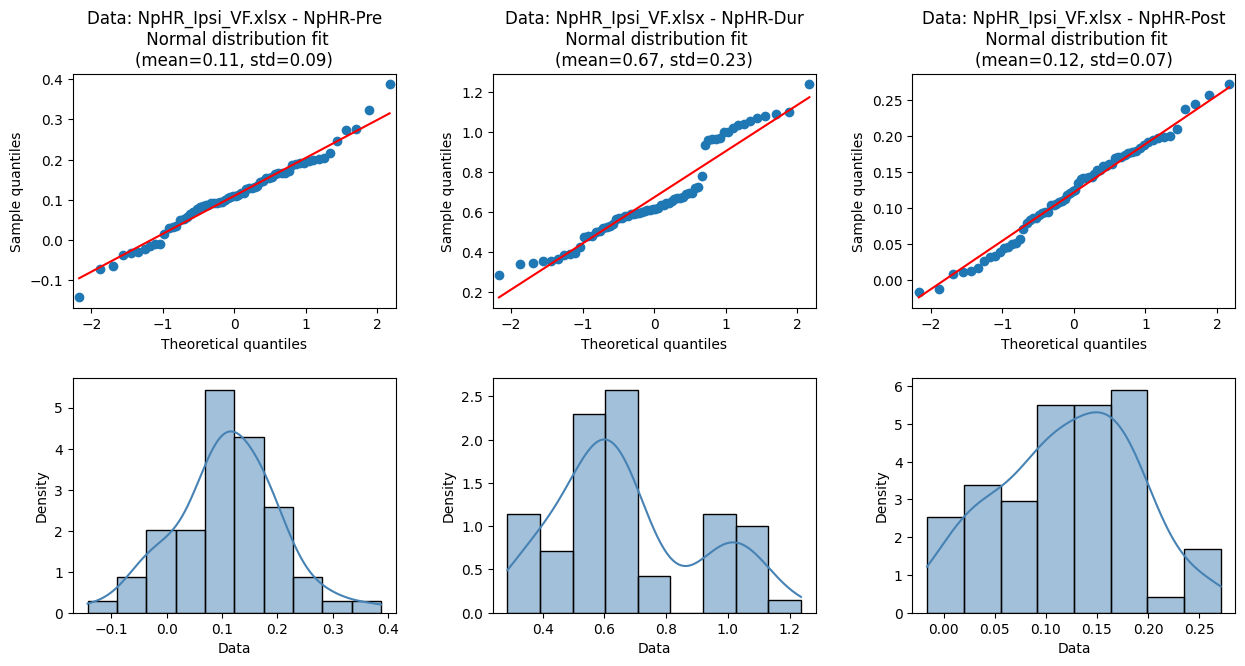

In [ ]:
dataset_normality_analysis()